In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
import joblib
from scipy.special import softmax
import sasc.config
import numpy as np
from collections import defaultdict
from copy import deepcopy
import pandas as pd
import imodelsx.linear_finetune
from sasc import analyze_helper
import sasc.viz
from sasc.modules.fmri_module import convert_module_num_to_voxel_num
from sasc.config import FMRI_DIR, RESULTS_DIR
import dvu
dvu.set_style()


[2023-11-22 16:14:22,874] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/thinc/compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/thinc/compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]


In [2]:
pilot_name = 'pilot3_story_data.pkl'

stories_data_dict = joblib.load(
    join(sasc.config.RESULTS_DIR, pilot_name))
if pilot_name == 'pilot2_story_data.pkl':
    pilot_data_dir = '/home/chansingh/mntv1/deep-fMRI/story_data/20230702'
elif pilot_name == 'pilot3_story_data.pkl':
    pilot_data_dir = '/home/chansingh/mntv1/deep-fMRI/story_data/20231106'

In [3]:
# load resps
polysemantic_story_idxs = np.where(
    np.array(stories_data_dict['story_setting']) == 'polysemantic')[0]
resp_np_files = [stories_data_dict['story_name_new'][i].replace('_resps', '')
                 for i in polysemantic_story_idxs]
resps_dict = {
    k: np.load(join(pilot_data_dir, k))
    for k in tqdm(resp_np_files)
}

mats = defaultdict(list)
for use_clusters in [False]:
    for story_num in polysemantic_story_idxs:
        print(story_num, stories_data_dict["story_name_new"][story_num])
        rows = stories_data_dict["rows"][story_num]

        # get resp_chunks
        resp_story = resps_dict[
            stories_data_dict["story_name_new"][story_num].replace(
                "_resps", "")
        ].T  # (voxels, time)
        timing = stories_data_dict["timing"][story_num]
        # paragraphs = story_data["story_text"][story_num].split("\n\n")
        # paragraphs = stories_data_dict["paragraphs"][story_num]
        if 'paragraphs' in stories_data_dict.keys():
            paragraphs = stories_data_dict["paragraphs"][story_num]
        else:
            paragraphs = stories_data_dict["story_text"][story_num].split(
                "\n\n")
        # assert len(paragraphs) == len(rows)
        # print(
        #     "times",
        #     timing["time_running"].max(),
        #     "resp TRs",
        #     resp_story.shape[1],
        #     "doubled",
        #     resp_story.shape[1] * 2,
        # )
        resp_chunks = analyze_helper.get_resps_for_paragraphs(
            timing, paragraphs, resp_story, offset=2
        )

        # calculate mat
        mat = np.zeros((len(rows), len(paragraphs)))
        # fill mat with nans
        mat[:] = np.nan

        print(f"{story_num=} {len(rows)=} {len(paragraphs)=} {len(resp_chunks)=}")
        # print(rows['expl1'])

        for i in range(len(paragraphs)):
            if i >= len(resp_chunks):
                mat[:, i] = np.nan
                break
            if use_clusters == False:
                mat[:, i] = resp_chunks[i][rows["voxel_num"].values].mean(
                    axis=1)
            elif use_clusters == True:
                for r in range(len(rows)):
                    cluster_nums = rows.iloc[r]["cluster_nums"]
                    if isinstance(cluster_nums, np.ndarray):
                        vals = resp_chunks[i][cluster_nums].flatten()
                        mat[r, i] = np.nanmean(vals)
                    else:
                        # print(cluster_nums)
                        mat[r, i] = np.nan
        mat[:, 0] = np.nan  # ignore the first column
        mat[:, -1] = np.nan  # ignore the last column
        # print('mat', mat)

        # sort by voxel_num
        args = np.argsort(rows["voxel_num"].values)
        mat = mat[args, :][:, args]
        # mat = mat[::2]  # only take even rows (since each row is duplicated)
        mats[use_clusters].append(deepcopy(mat))

        # plt.imshow(mat)
        plt.show()
rows = rows.sort_values(by="voxel_num")
expls = rows["expl"].values


m = {}
for use_clusters in [False, True]:
    mats[use_clusters] = np.array(
        mats[use_clusters]
    )  # (num_stories, num_voxels, num_paragraphs)
    m[use_clusters] = np.nanmean(mats[use_clusters], axis=0)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:03<00:00,  1.99s/it]

4 GenStory16_resps.npy
story_num=4 len(rows)=16 len(paragraphs)=16 len(resp_chunks)=16
5 GenStory17_resps.npy
story_num=5 len(rows)=16 len(paragraphs)=16 len(resp_chunks)=14



/tmp/ipykernel_818693/2958126153.py:88: RuntimeWarning: Mean of empty slice
  m[use_clusters] = np.nanmean(mats[use_clusters], axis=0)


### Make average plot

<>:37: DeprecationWarning: invalid escape sequence '\s'
<>:37: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_818693/2385510062.py:37: DeprecationWarning: invalid escape sequence '\s'
  plt.ylabel('Mean voxel response ($\sigma_f$)')


mean 0.06447288931178476
median 0.04739847090590353


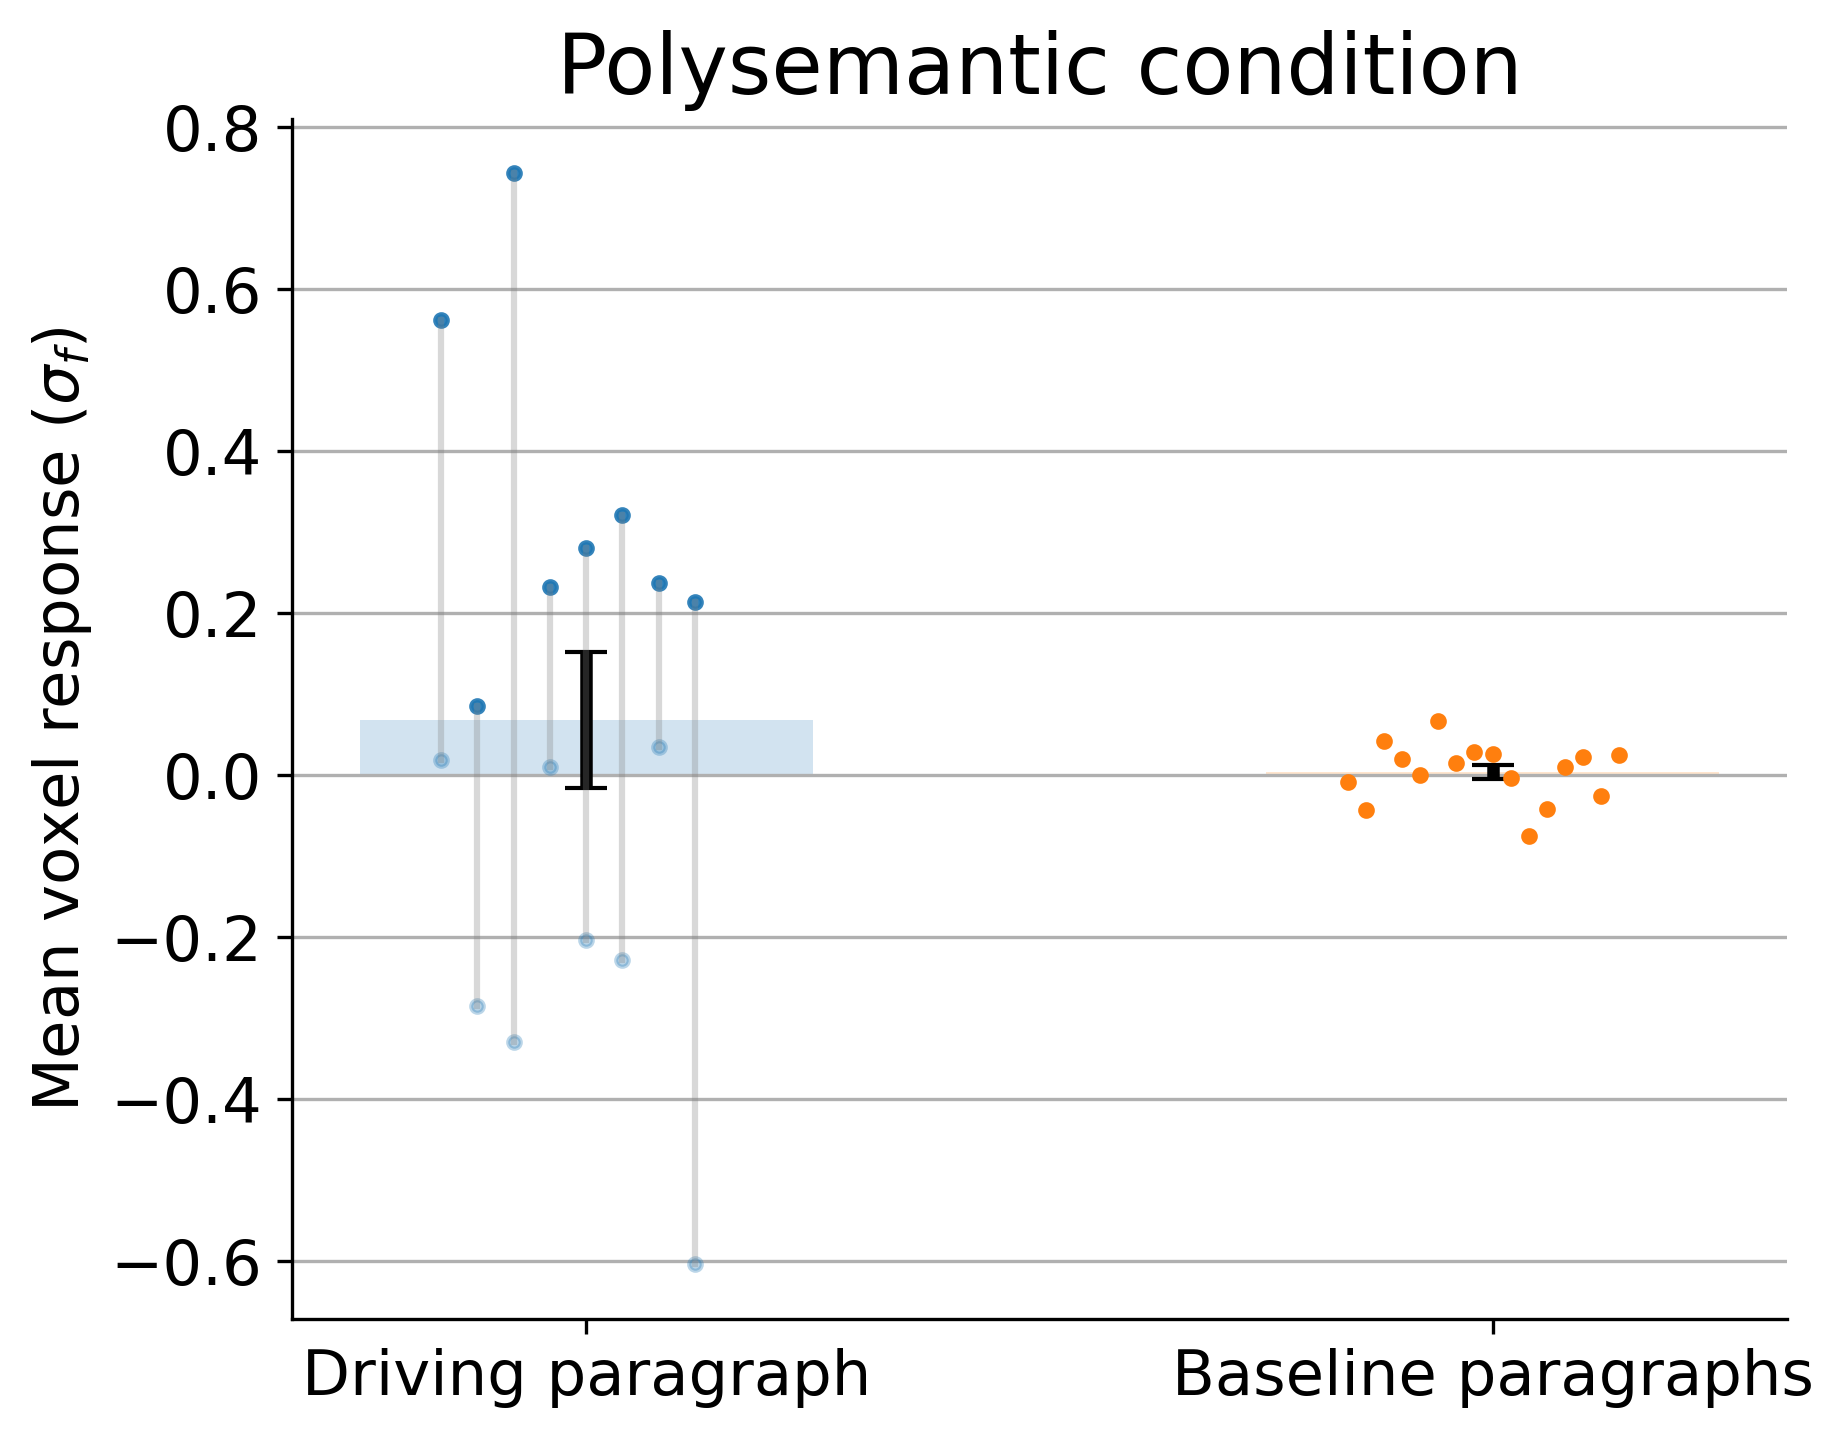

In [4]:
# calculate means
use_clusters = False
m1 = m[use_clusters]

n = m1.shape[0]
diag_means = np.diag(m1)
diag_mean = np.nanmean(diag_means)

# get mean of each row excluding the diagonal
off_diag_means = np.nanmean(m1, axis=1) - (diag_means / n)
off_diag_mean = np.nanmean(off_diag_means)

# make plot
plt.figure(dpi=300)
x = np.arange(n) - n / 2
plt.bar(1, diag_mean, width=0.5, label='Diagonal', alpha=0.2, color='C0')
plt.errorbar(1, diag_mean, yerr=np.nanstd(diag_means) / np.sqrt(len(diag_means)),
             fmt='.', label='Diagonal', ms=0, color='black', elinewidth=3, capsize=5, lw=1)
# plt.plot(1 + x/50, diag_means, '.', color='C0', alpha=0.5)
for i in range(0, len(diag_means), 2):
    bigger = max(diag_means[i], diag_means[i + 1])
    smaller = min(diag_means[i], diag_means[i + 1])
    plt.plot(1 + (i-n/2)/50, bigger, '.', color='C0', alpha=0.9)
    plt.plot(1 + (i-n/2)/50, smaller, '.', color='C0', alpha=0.3)
    # draw line between the 2 points
    plt.plot([1 + (i-n/2)/50, 1 + (i-n/2)/50],
             [bigger, smaller], color='gray', alpha=0.3)


plt.bar(2, off_diag_mean, width=0.5,
        label='Off-diagonal', alpha=0.2, color='C1')
plt.errorbar(2, off_diag_mean, yerr=np.nanstd(off_diag_means) / np.sqrt(len(off_diag_means)),
             fmt='.', label='Diagonal', ms=0, color='black', elinewidth=3, capsize=5)
plt.plot(2 + x/50, off_diag_means, '.', color='C1')

plt.xticks([1, 2], ['Driving paragraph', 'Baseline paragraphs'])
plt.ylabel('Mean voxel response ($\sigma_f$)')
plt.grid(axis='y')

plt.tight_layout()
print('mean', diag_mean - off_diag_mean)
print('median', np.nanmedian(diag_means) - np.nanmedian(off_diag_means))
plt.title('Polysemantic condition')
# plt.title(f'use_clusters={use_clusters}')
plt.savefig(join(RESULTS_DIR, 'figs/main',
            pilot_name[:pilot_name.index('_')] + '_poly_means.pdf'))

### Relationship between different voxels

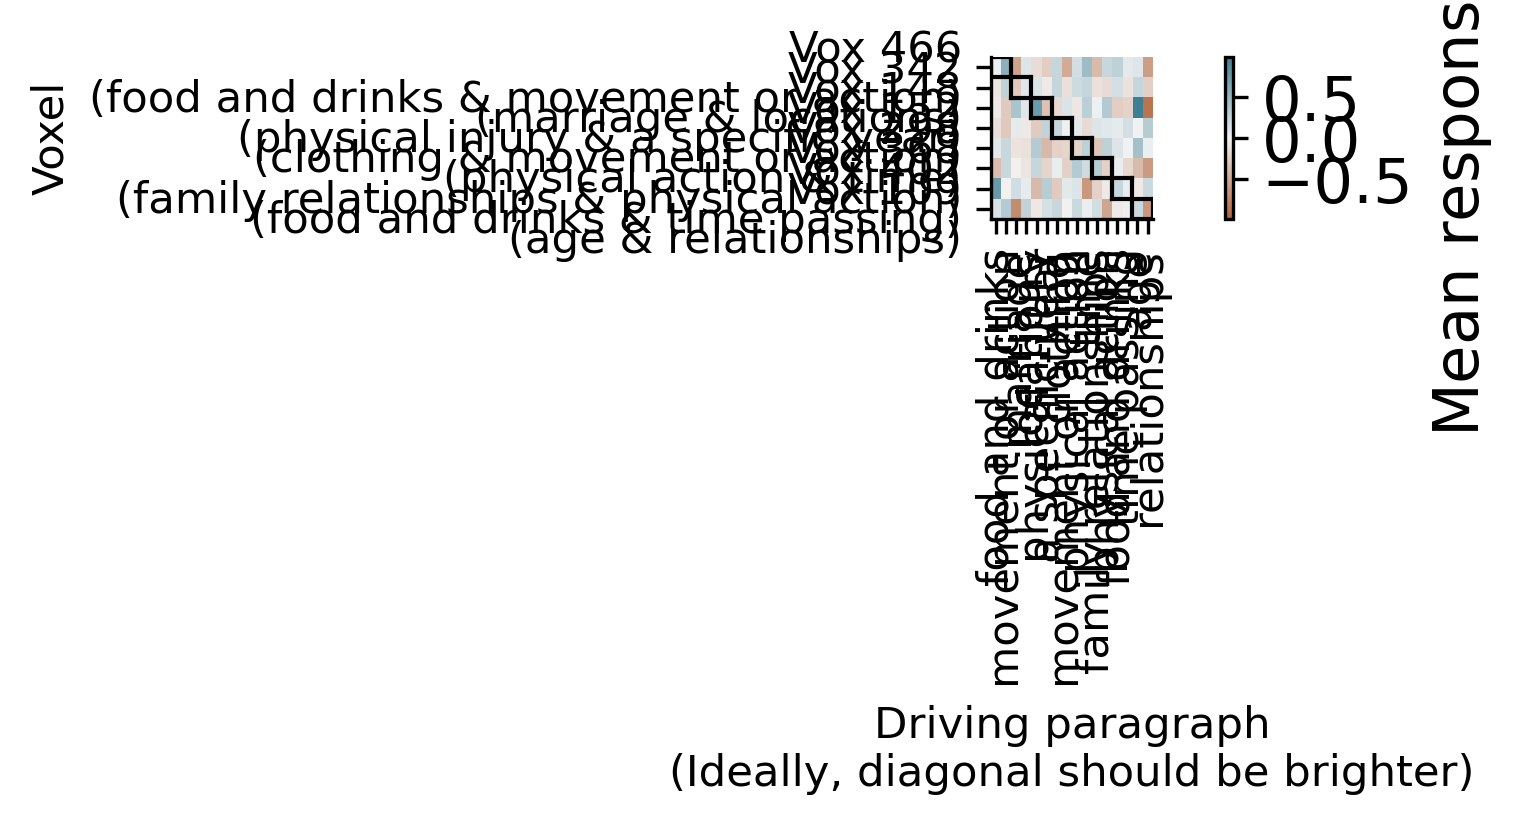

In [5]:
# note: some voxels didn't have good clusters so they will be missing from these plots...
use_clusters = False
m1 = m[use_clusters]
# cg = sns.clustermap(pd.DataFrame(m, columns=expls, index=expls), method='complete', cmap='viridis', figsize=(10, 10))
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# plt.xlabel('Driving paragraph')
plt.figure(figsize=(6, 3), dpi=300)
# m = softmax(m, axis=0)

sasc.viz.outline_diagonal(m1.shape, color='black', lw=1, block_size=2)

# expls_order = analyze_helper.sort_expls_semantically(expls)
expls_order = np.arange(len(expls))
m_plot = m1[expls_order][:, expls_order]  # [:, expls_order]
# m_plot = m1
sasc.viz.imshow_diverging(m_plot)
plt.xlabel(
    "Driving paragraph\n(Ideally, diagonal should be brighter)", fontsize="x-small"
)
plt.ylabel("Voxel", fontsize="x-small")
vox_names = []
for i in range(0, len(rows), 2):
    vox_names.append(
        "Vox "
        + str(rows["module_num"].values[i])
        + "\n("
        + rows["expl"].values[i]
        + ' & ' + rows["expl"].values[i + 1]
        + ")"
    )
# plt.yticks(labels=expls_with_num.values[expls_order], ticks=np.arange(len(expls)), fontsize='x-small')
plt.yticks(labels=vox_names, ticks=0.5 +
           np.arange(len(vox_names)) * 2, fontsize="x-small")
plt.xticks(
    labels=expls[expls_order],
    ticks=np.arange(len(expls)),
    rotation=90,
    fontsize="x-small",
)
plt.savefig(join(RESULTS_DIR, 'figs/main',
            pilot_name[:pilot_name.index('_')] + '_poly_heatmap.pdf'))
plt.show()

# plot correlations across all resps
# resps_voxels = np.concatenate(
#     [resps_dict[story_data["story_name_new"][story_num]].T for story_num in [2, 3, 4]],
#     axis=1,
# )[rw["voxel_num"].values]
# corr = pd.DataFrame(resps_voxels.T, columns=expls).corr().round(2)
# sns.clustermap(corr)

<>:9: DeprecationWarning: invalid escape sequence '\s'
<>:9: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_3737849/297493464.py:9: DeprecationWarning: invalid escape sequence '\s'
  plt.ylabel("Mean voxel response ($\sigma_f$), driving paragraphs")


,voxel_num,expl,roi_anat,roi_func,test_corr_new,resp_driving
731,35484,movement,"[inferiorparietal, middletemporal]",--,0.25,1.07
805,59423,food preparation,[rostralmiddlefrontal],[PMvh],0.11,0.92
632,29226,something negative or undesirable,[middletemporal],"[ATFP, AC]",0.35,0.35
935,55978,location,[inferiorparietal],[ATFP],0.18,0.31
935,55978,action,[inferiorparietal],[ATFP],0.18,0.26
731,35484,moment in time,"[inferiorparietal, middletemporal]",--,0.25,0.26
1312,51132,food,"[parstriangularis, rostralmiddlefrontal]",[ATFP],0.11,0.20
1088,46944,fear,"[inferiorparietal, supramarginal]","[pSTS, PMvh]",0.28,0.18
30,35580,illness,[middletemporal],"[pSTS, ATFP]",0.08,0.17
1312,51132,clothing,"[parstriangularis, rostralmiddlefrontal]",[ATFP],0.11,0.08


/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


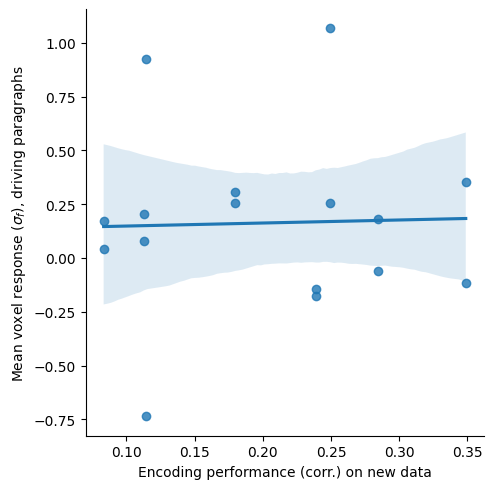

In [14]:
rows["resp_driving"] = np.diag(m[use_clusters])
display(
    rows[["voxel_num", "expl", "roi_anat",
          "roi_func", "test_corr_new", "resp_driving"]]
    .sort_values(by="resp_driving", ascending=False)
    .round(2)
)
sns.lmplot(data=rows, x="test_corr_new", y="resp_driving")
plt.ylabel("Mean voxel response ($\sigma_f$), driving paragraphs")
plt.xlabel("Encoding performance (corr.) on new data")
plt.show()

### Story-level differences

<>:21: DeprecationWarning: invalid escape sequence '\s'
<>:21: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_3737849/1530193502.py:21: DeprecationWarning: invalid escape sequence '\s'
  plt.ylabel('Mean voxel response ($\sigma_f$)')


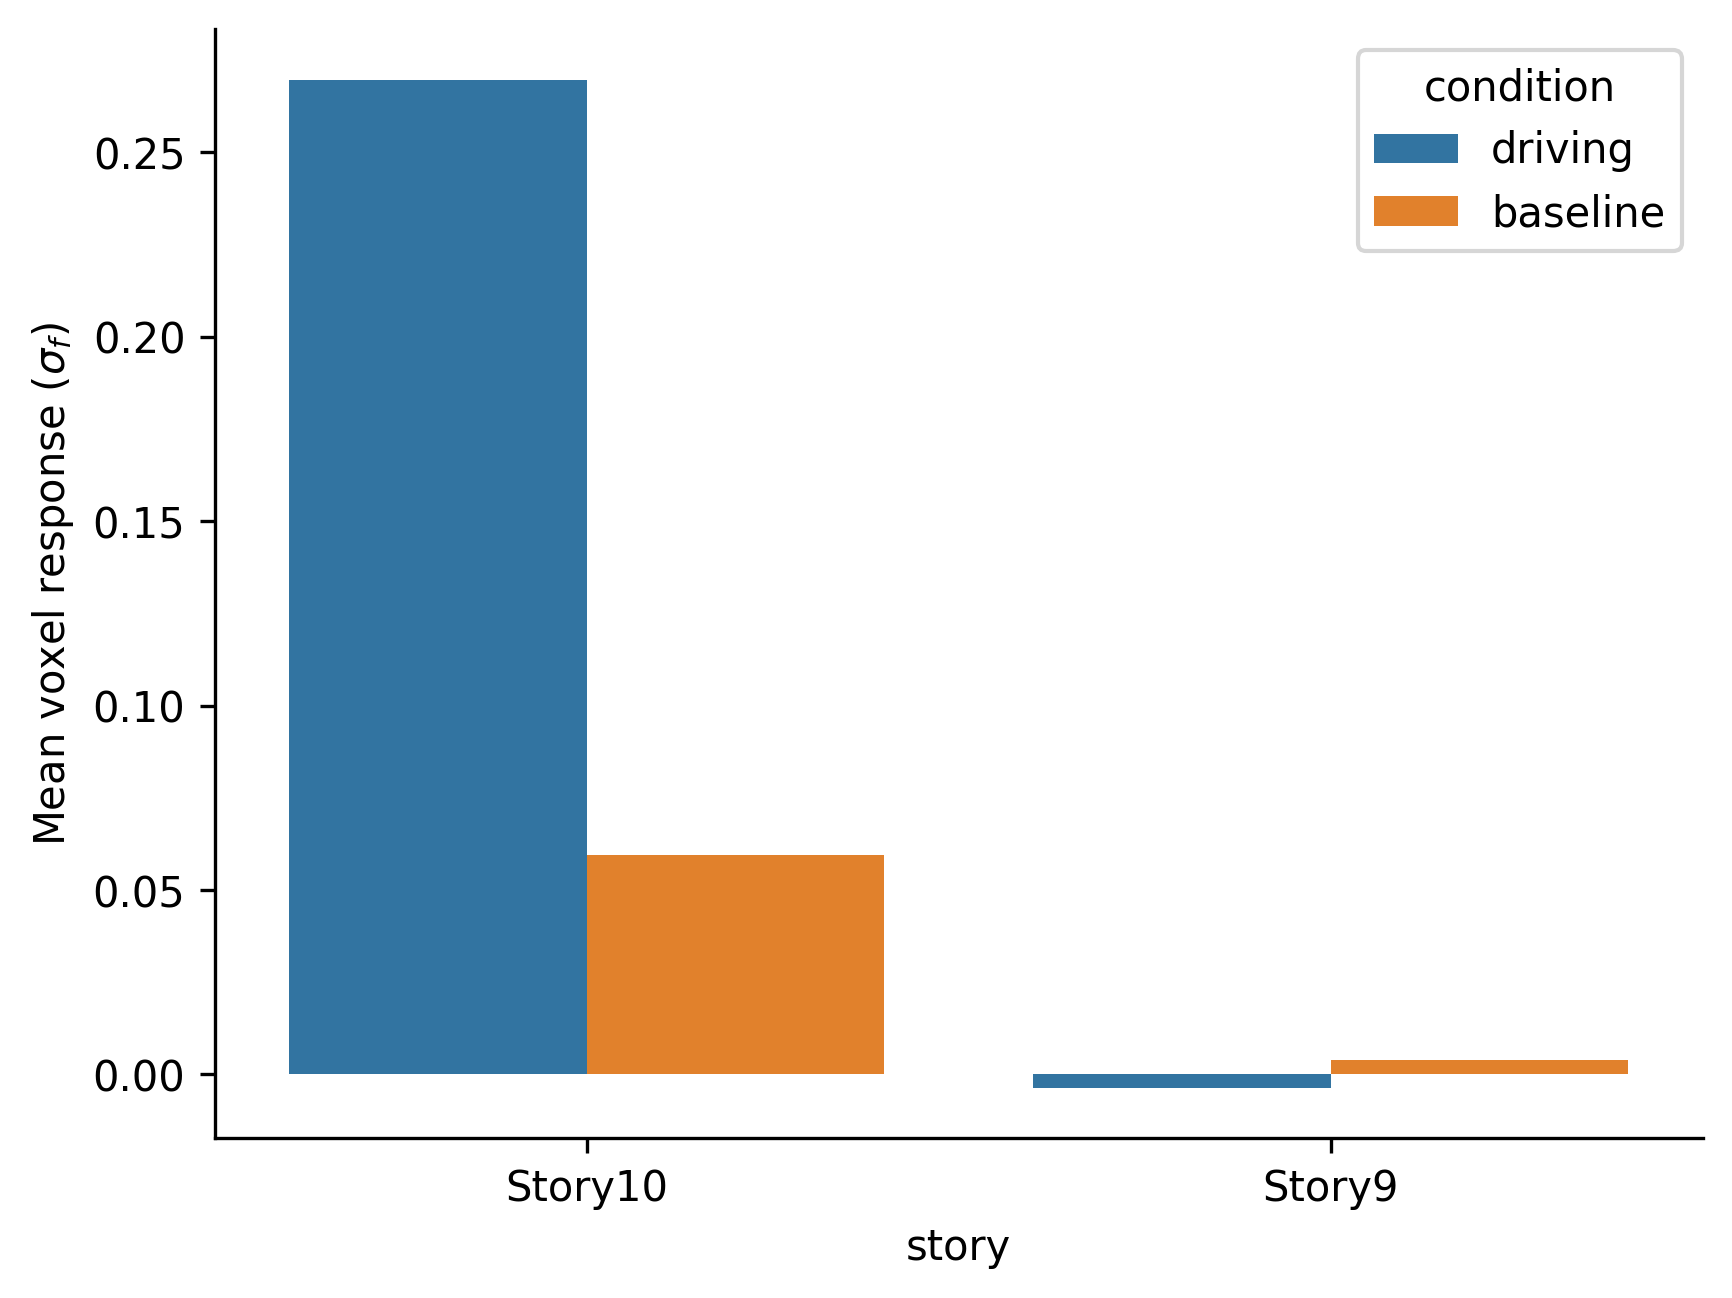

In [15]:
use_clusters = False
mats1 = mats[use_clusters]

d = defaultdict(list)
STORY_NUMS = [2, 3]
for i in range(len(mats1)):
    m = mats1[i]
    d['driving'].append(np.nanmean(np.diag(m)))
    d['baseline'].append(np.nanmean(m[~np.eye(m.shape[0], dtype=bool)]))
    d['story'].append(stories_data_dict['story_name_new']
                      [STORY_NUMS[i]][3:-10])

df = pd.DataFrame.from_dict(d)

# make barplot comparing driving and baseline
df = df.melt(id_vars='story', value_vars=[
             'driving', 'baseline'], var_name='condition', value_name='mean')
df = df.sort_values(by='story')
plt.figure(dpi=300)
sns.barplot(data=df, x='story', y='mean', hue='condition')
plt.ylabel('Mean voxel response ($\sigma_f$)')
plt.savefig(join(RESULTS_DIR, 'figs/main',
            pilot_name[:pilot_name.index('_')] + '_poly_story_breakdown.pdf'))
plt.show()